<a href="https://colab.research.google.com/github/ougrid/my-knowledge-resource/blob/master/Creating_an_AI_Driven_Restaurant_Menu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Scenario

As an aspiring entrepreneur with a passion for the food industry, you embark on the challenging journey of opening a restaurant. The process is not a simple feat, as it involves numerous tasks such as finding a suitable location, naming the establishment, hiring staff, and crafting a delectable menu.

While outsourcing these tasks is an option, it can be costly. Therefore, you decide to embrace the challenge and explore the potential of Generative AI, a rapidly growing field that is revolutionizing various industries. You believe that this technology can significantly simplify and enhance the process of starting your food business.


# Environment Setup

In this section, you will prepare all the essential dependencies required for the upcoming session.

## Install Vertex AI SDK

In [ ]:
! pip install --upgrade --quiet --user google-cloud-aiplatform

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.6 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


## Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. Please don't worry about the pop up messages. ⚠️</b>
</div>

## Authenticate your notebook environment (Colab only)

If you're using Google Colab to run this notebook, you'll need to authenticate your environment. To do this, run the new cell below.

This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).

In [ ]:
import sys

# Addtional authentication is required for Google Colab
if 'google.colab' in sys.modules:

    # Authenticate user to Google Cloud
    from google.colab import auth
    auth.authenticate_user()

## Define Google Cloud project information (Colab only)

If you're using Google Colab, you'll need to specify your Google Cloud project information. In the cell below, you'll define this information, import the Vertex AI package, and initialize it.

This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).

In [ ]:
import sys

if 'google.colab' in sys.modules:

    # Define project information
    PROJECT_ID = "replace-with-your-project-id" # @param {type:"string"}
    PROJECT_ID = "public-demo-gallery"
    LOCATION = "us-central1" # @param {type:"string"}

    # Initialize Vertex AI
    import vertexai
    vertexai.init(project=PROJECT_ID, location=LOCATION)

# Ideation

Here you will use Generative AI to assist you in idiating restaurent name and menu items


In [ ]:
from vertexai.language_models import TextGenerationModel

text_generation_model = TextGenerationModel.from_pretrained("text-bison@002")

In [ ]:
# ideate names for the restaurent

prompt = "Generate 10 trendy and modern restaurant names:"

text_response = text_generation_model.predict(
    prompt=prompt,
)

text_response

 1. **The Urban Fork**
2. **The Modern Table**
3. **The Culinary Collective**
4. **The Flavor Lab**
5. **The Food Atelier**
6. **The Gastronomic Hub**
7. **The Culinary Loft**
8. **The Kitchen Studio**
9. **The Food Lab**
10. **The Culinary Workshop**

In [ ]:
# populate menu items

prompt = """
  Provide a menu with description for breakfast, lunch, dinner. Also include dessert and drink options.
  Format the output into Json format with keys (menu, breakfast, lunch, dinner, dessert, drink, name, description).
  Don't include the json decorator.
"""

text_response = text_generation_model.predict(
    prompt=prompt,
    max_output_tokens=2048,
)

text_response

 {
  "menu": {
    "breakfast": [
      {
        "name": "Scrambled Eggs",
        "description": "Fluffy scrambled eggs served with your choice of breakfast potatoes or toast."
      },
      {
        "name": "Oatmeal",
        "description": "Hearty oatmeal topped with your choice of fresh fruit, nuts, or brown sugar."
      },
      {
        "name": "Yogurt Parfait",
        "description": "Layers of yogurt, granola, and fresh fruit."
      }
    ],
    "lunch": [
      {
        "name": "Grilled Cheese Sandwich",
        "description": "Classic grilled cheese sandwich made with your choice of cheese and bread."
      },
      {
        "name": "Chicken Salad Sandwich",
        "description": "Fresh chicken salad served on your choice of bread."
      },
      {
        "name": "Soup and Salad",
        "description": "A cup of soup and a fresh salad."
      }
    ],
    "dinner": [
      {
        "name": "Steak",
        "description": "Grilled steak served with your choice of 

# Visualing

Here you will use Imagen to visualize the items from the menu using their descriptions.

## Define auxillary functions

In this section, you will define the auxiliary functions that will be used later in the notebook. These functions will help you to perform the following tasks
- getting the access token from Google Cloud SDK
- generating payload data in json format
- sending request to the REST API endpoint
- showing generated images in a grid, and so on.

In [ ]:
import base64
import json
import math
import os
import requests
import subprocess
from io import BytesIO

import matplotlib.pyplot as plt
from PIL import Image


os.environ["PREDICTION_ENDPOINT"] = (
    f"https://{LOCATION}-aiplatform.googleapis.com/v1/"
    f"projects/{PROJECT_ID}/locations/{LOCATION}/"
    f"publishers/google/models/imagegeneration:predict"
)


def get_access_token():
  """Gets the access token from the Google Cloud SDK.

  Returns:
    The access token.

  Raises:
    Exception: If something went wrong with getting the access token.
  """

  access_token = subprocess.run(
      ["gcloud", "auth", "print-access-token"],
      capture_output=True,
      text=True,
  ).stdout.strip()

  if access_token.startswith("ya29"):
    return access_token
  else:
    raise Exception(
        f"Something went wrong with getting the access token."
        f"Restart the notebook and login again.\n {access_token}"
    )


def generate_payload_json(access_token, prompt, **kwargs):
  """Generates the JSON data for the API request.

  Args:
    access_token: The access token for the API.
    prompt: The prompt for the image generation.
    **kwargs: Optional parameters for the API request.

  Returns:
    A tuple of the headers and the JSON data.
  """

  number_of_images = kwargs.get("number_of_images")
  negative_prompt = kwargs.get("negative_prompt")
  image_size = kwargs.get("image_size")
  guidance_scale = kwargs.get("guidance_scale")
  seed = kwargs.get("seed")
  base_image = kwargs.get("base_image")
  mask = kwargs.get("mask")
  mode = kwargs.get("mode")

  headers = {
    "Authorization": f"Bearer {access_token}",
    "Content-Type": "application/json; charset=utf-8",
  }

  data = {
    "instances": [
      {
        "prompt": prompt,
      }
    ],
    "parameters": {
      "negativePrompt": negative_prompt,
      "sampleCount": number_of_images,
      "sampleImageSize": image_size,
      "seed": seed,
      "guidanceScale": guidance_scale,
      "mode": mode,
    }
  }

  return headers, json.dumps(data)


def send_request(headers, data):
  """Sends a POST request to the specified endpoint.

  Args:
    headers: A dictionary of headers to include in the request.
    data: The data to send in the request body.

  Returns:
    The JSON response from the endpoint.

  Raises:
     requests.exceptions.HTTPError: If the status code of the response is not 200.
  """
  endpoint = os.environ["PREDICTION_ENDPOINT"]
  response = requests.post(endpoint, headers=headers, data=data)

  if response.status_code != 200:
    raise requests.exceptions.HTTPError(
        f"Error: {response.status_code} ({response.reason})")

  return response.json()


def generate_images(prompt, **kwargs):
  """Generates images from the prompt.

  Args:
    prompt: The prompt to generate images from.
    **kwargs: Keyword arguments to pass to the prediction API.

  Returns:
    A list of Image objects.
  """
  access_token = get_access_token()
  headers, data = generate_payload_json(access_token, prompt, **kwargs)
  response = send_request(headers, data)

  images = []
  if response:
    for pred in response["predictions"]:
      b64_decoded_string = base64.b64decode(pred["bytesBase64Encoded"])
      img = Image.open(BytesIO(b64_decoded_string))
      images.append(img)
    return images


## Generate menu items

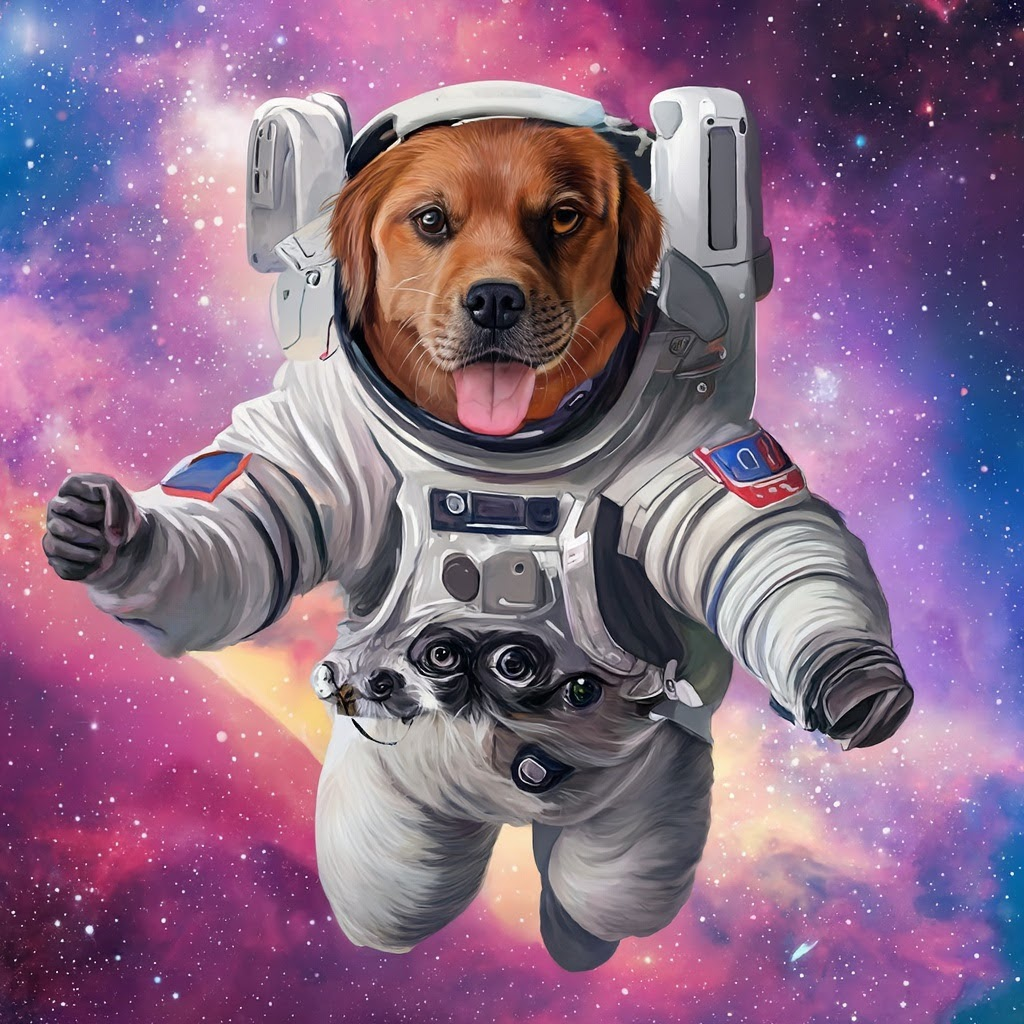

In [ ]:
prompt = "A photorealistic painting of a dog in a spacesuit floating in the middle of a nebula."

images = generate_images(
    prompt=prompt,
    number_of_images=1,
)

display(images[0])

In [ ]:
# convert the response into json

import json

json_response = json.loads(text_response.text)
json_response["menu"]["breakfast"]

[{'name': 'Scrambled Eggs',
  'description': 'Fluffy scrambled eggs served with your choice of breakfast potatoes or toast.'},
 {'name': 'Oatmeal',
  'description': 'Hearty oatmeal topped with your choice of fresh fruit, nuts, or brown sugar.'},
 {'name': 'Yogurt Parfait',
  'description': 'Layers of yogurt, granola, and fresh fruit.'}]

In [ ]:
# convert the item description to an image prompt

item = json_response["menu"]["breakfast"][0]
prompt = f"Rewrite this {item} an image prompt"

text_response = text_generation_model.predict(
    prompt=prompt,
)

text_response

 A plate of fluffy scrambled eggs, served with a side of breakfast potatoes and toast. The eggs are golden brown and cooked to perfection, with a creamy texture and a hint of salt. The breakfast potatoes are crispy on the outside and soft on the inside, seasoned with herbs and spices. The toast is golden brown and buttered, providing a perfect base for the eggs and potatoes. The plate is garnished with a sprig of parsley and a wedge of lemon.

In [ ]:
# define into a function

def convert_into_image_prompt(item):
  image_prompt = text_generation_model.predict(
      prompt=f"Rewrite this {item} an image prompt",
  ).text.strip()

  return image_prompt

convert_into_image_prompt(item)

'A plate of fluffy scrambled eggs, served with a side of breakfast potatoes and toast. The eggs are golden brown and cooked to perfection, with a creamy texture and a hint of salt. The breakfast potatoes are crispy on the outside and soft on the inside, seasoned with herbs and spices. The toast is golden brown and buttered, providing a perfect base for the eggs and potatoes. The plate is garnished with a sprig of parsley and a wedge of lemon.'

In [ ]:
# generate image prompts for a category

import textwrap

category = "breakfast"
image_prompts = []

for item in json_response["menu"][category]:
  prompt = convert_into_image_prompt(item)
  image_prompts.append(prompt)

A plate of fluffy scrambled eggs, served with a side of breakfast potatoes and toast. The eggs are golden brown and
cooked to perfection, with a creamy texture and a hint of salt. The breakfast potatoes are crispy on the outside and
soft on the inside, seasoned with herbs and spices. The toast is golden brown and buttered, providing a perfect base for
the eggs and potatoes. The plate is garnished with a sprig of parsley and a wedge of lemon. 



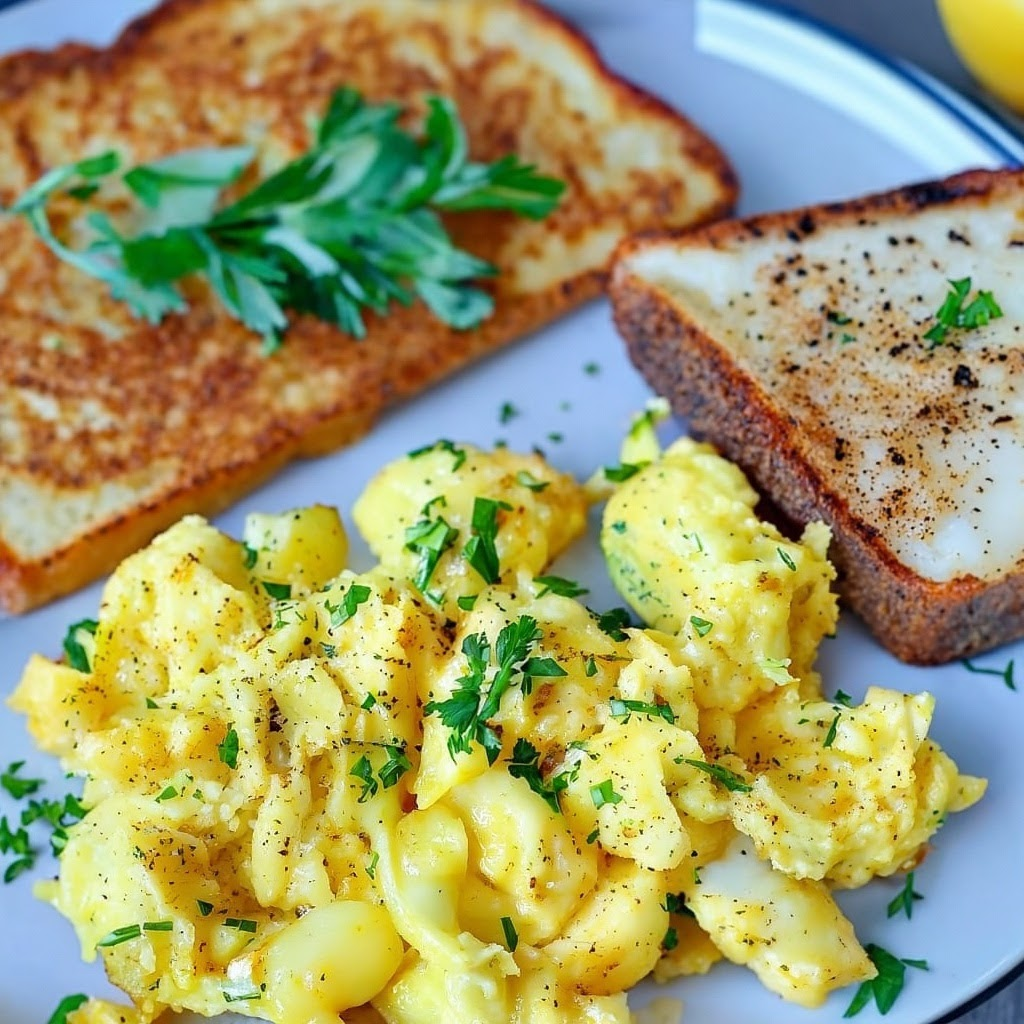

In [ ]:
image_prompt = image_prompts[0]

print(textwrap.fill(image_prompt, 120), "\n")

images = generate_images(
    prompt=image_prompt,
    number_of_images=1,
)

display(images[0])

# Conclusion

You have succeefuully create a professional resturant menu all by yourself! Imagen on Vertex AI can do much more that generating realistic images. Explore all the features